##############ReadMe
The circuit simulator is implimented in the simulate() function but calls on outside functions for creating the matricies for the gates. These functions are sing_gate() and CNOT(). The QASM file was read differently to the simulator comparison file in that each line of instructions was placed into a list and then this list was iterated through to find gates needed.

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from qutip import *
import re
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [3]:
#####Creating gates defined in files
I=[[1,0],[0,1]]
h=[[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]]
x=[[0,1],[1,0]]
t=[[1,0],[0,np.exp(np.pi*1j/4)]]
tdg=[[1,0],[0,np.exp(-np.pi*1j/4)]]
zero=[[1,0],[0,0]]
one=[[0,0],[0,1]]
print(np.multiply(h,I))

[[ 0.70710678  0.        ]
 [ 0.         -0.70710678]]


In [4]:
########Function to create matrix for each gate 

def sing_gate(K,l,N):       #Function creates matrix to represent single qubit gate K in index l in N qubit register
    master_list=[0]*N
    for i in range(len(master_list)):
        master_list[i]=I
    master_list[l]=K
    Matrix=master_list[0]
    for i in range(1,N):
        Matrix=np.kron(Matrix,master_list[i])
    return(Matrix)
print(sing_gate(x,0,1))

[[0, 1], [1, 0]]


In [5]:
######Separate Method for CNOT

def CNOT(c,t,N):       #Function creates matrix to represent CNOT with control index c and target index c in register of length N
    master_list1=[0]*N
    for i in range(len(master_list1)):
        master_list1[i]=I
    master_list1[c]=zero
    master_list2=[0]*N
    for i in range(len(master_list2)):
        master_list2[i]=I
    master_list2[c]=one
    master_list2[t]=x
    Matrix1=master_list1[0]
    for i in range(1,N):
        Matrix1=np.kron(Matrix1,master_list1[i])
    Matrix2=master_list2[0]
    for i in range(1,N):
        Matrix2=np.kron(Matrix2,master_list2[i])
    return(Matrix1+Matrix2)
print(CNOT(0,1,2))

[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]


In [6]:
file_path = r'C:\Users\35386\Downloads\decod24-v2_43.qasm'
with open(file_path, 'r') as file:
    instructions = file.readlines()


In [7]:
qasm_lines = instructions  #####This creats a list where each entry is a string of the qasm line

In [8]:
def simulate(qasm_lines): ######Simulation function
    Matricies=[]
    N_list=[]
    for i in qasm_lines:  #Finding number of qubits actually used for simulation and setting N as that to speed up runtime
        if i.startswith("h") or i.startswith("x") or i.startswith("t ") or i.startswith("tdg") or i.startswith("cx"):
            N_list.append(int(re.findall(r'\d+',i)[0]))
        if i.startswith("cx"):
            N_list.append(int(re.findall(r'\d+',i)[1]))
    N=max(N_list)+1
    for i in qasm_lines:    ## Reading instructiond from file and then creating matrix for each gate
        if i.startswith("creg"):
            n=int(re.findall(r'\d+',i)[0])##########Number of classical bits
        if i.startswith("h"):
            l=int(re.findall(r'\d+',i)[0])
            Matricies.append(sing_gate(h,l,N))
        if i.startswith("x"):
            l=int(re.findall(r'\d+',i)[0])
            Matricies.append(sing_gate(x,l,N))
        if i.startswith("t "):
            l=int(re.findall(r'\d+',i)[0])
            Matricies.append(sing_gate(t,l,N))
        if i.startswith("tdg"):
            l=int(re.findall(r'\d+',i)[0])
            Matricies.append(sing_gate(tdg,l,N))
        if i.startswith("cx"):
            c=int(re.findall(r'\d+',i)[0])
            tar=int(re.findall(r'\d+',i)[1])
            Matricies.append(CNOT(c,tar,N))
    Matricies = [array.tolist() for array in Matricies]
    
    Zero=[[1],[0]]
    One=[[0],[1]]
    #print(N)
    #####Creating input state od |000...>
    input_state=Zero
    for i in range(1,N):
        input_state=np.kron(input_state,Zero)

    #Passing input state through each gate
    new_state=input_state
    for i in range(len(Matricies)):
        new_state=np.matmul(Matricies[i],new_state)
    #Getting rid of rounding errors
    for i in range(len(new_state)):
        new_state[i]=np.round(new_state[i],4)
    new_state=np.transpose(new_state)
    return(new_state)
    #print(new_state)

In [9]:
print(simulate(qasm_lines))  ##Output statevector of decod24-v2_43 confirms validity

[[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  -0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j]]


In [10]:
pip install cirq

Note: you may need to restart the kernel to use updated packages.


In [11]:
import sys
import numpy as np
import cirq
from cirq.contrib.qasm_import import circuit_from_qasm
from pathlib import Path

# Import your simulate function here.
# cs238 can be a file, a folder with an __init__.py file,
#from cs238 import simulate


def cirq_simulate(qasm_string: str) -> list:
    """Simulate a qasm string

    Args:
        qasm_string: a string following the qasm format

    Returns:
        statevector: a list, with a complex number for
            each of the 2^num_qubits possible amplitudes
            Ordered big endian, see:
        quantumai.google/reference/python/cirq/sim/StateVectorTrialResult#state_vector
    """

    circuit = circuit_from_qasm(qasm_string)
    result = cirq.Simulator().simulate(circuit)
    statevector = list(np.around(result.state_vector(), 3))
    return statevector


def compare(state_vector, cirq_state_vector):
    """Our comparison function for your grade

    Args:
        state_vector: your state vector amplitude list
        cirq_state_vector: cirq's state vector amplitude list

    Returns:
        Some value influencing your grade, subject to change :)
    """

    return np.all(np.isclose(state_vector, cirq_state_vector))

print(cirq_simulate(qasm_string))
# get the directory of qasm files and make sure it's a directory
qasm_dir = Path(sys.argv[1])
assert qasm_dir.is_dir()

# iterate the qasm files in the directory
for qasm_file in qasm_dir.glob("**/*.qasm"):
    # read the qasm file
    with open(qasm_file, "r") as f:
        qasm_string = f.read()

    # run your simulate function on the qasm string
    state_vector = simulate(qasm_string)
    # run cirq's simulator on the qasm string
    cirq_state_vector = cirq_simulate(qasm_string)
    # compare the results!
    print(compare(state_vector, cirq_state_vector))


NameError: name 'qasm_string' is not defined

In [12]:
import time
tests = ['miller_11 (1)', 'decod24-v2_43 (1)', 'one-two-three-v3_101', 'hwb5_53', 'alu-bdd_288', 'f2_232', 'con1_216', 'mini_alu_305']
time_list = []
valid = []
qubits = np.array(range(len(tests))) + 3

for test in tests:
    qasm_file = r'C:\Users\35386\Documents\Qasm Files\{}.qasm'.format(test)
    with open(qasm_file, "r") as file:
        instructions = file.readlines()
        qasm_string = file.read()
        qasm_lines = instructions 
        #print(qasm_lines)
        start_time = time.time()
        state_vector = simulate(qasm_lines)
        #print(simulate(qasm_lines))
        end = time.time()
        elapsed_time = end - start_time
        time_list.append(elapsed_time)
        # run cirq's simulator on the qasm string
        #cirq_state_vector = cirq_simulate(qasm_string)
        # compare the results!
        #print(state_vector,cirq_state_vector)
        #print(validity)
        #valid.append(validity)
        

Text(0, 0.5, 'Simulator Runtime')

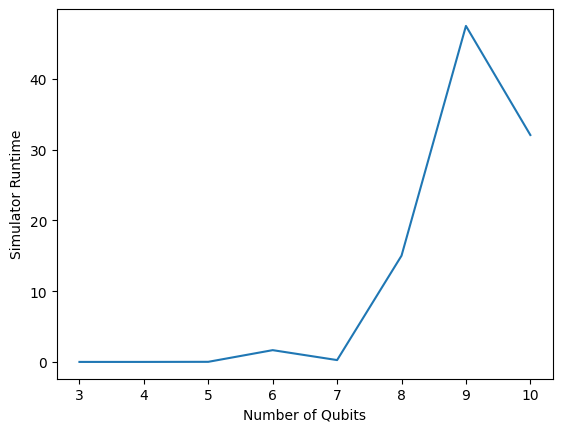

In [13]:
num_qubits=[3,4,5,6,7,8,9,10]
plt.plot(num_qubits,time_list)
plt.xlabel("Number of Qubits")
plt.ylabel("Simulator Runtime")